In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import numpy as np
import os
import time
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [4]:
from pydrake.all import (
    StartMeshcat,
    CollisionCheckerParams,
    RobotDiagramBuilder,
    MeshcatVisualizer,
    Parser,
    LoadModelDirectives,
    ProcessModelDirectives,
    SceneGraphCollisionChecker,
    AutoDiffXd,
    RigidTransform_,
    IrisNp2Options,
    IrisZoOptions,
    IrisParameterizationFunction,
    MathematicalProgram,
    HPolyhedron,
    IrisNp2,
    IrisZo,
    Hyperellipsoid,
    RandomGenerator,
    ComputePairwiseIntersections,
    GcsTrajectoryOptimization,
    Point,
    GraphOfConvexSetsOptions,
    FunctionHandleTrajectory,
    InitializeAutoDiff,
    ExtractGradient,
    Toppra,
    PathParameterizedTrajectory,
)

In [5]:
import src.iiwa_analytic_ik as iiwa_analytic_ik
import src.common as common
import src.rrt as rrt
import src.shortcut as shortcut

# Parameters

In [21]:
directives_file = os.path.join(common.RepoDir(), "models/old_shelves.dmd.yaml")
grasp_distance = 0.6
GC2 = 1
GC4 = 1
GC6 = -1
q_tilde_start = np.array([2.7165428034875583, -1.6020894107055366, -2.2310925417095118, -1.1273910985350377, -2.4662887005324756, -1.0705505639656554, -2.0129979825706337, 1.38])
q_tilde_goal = np.array([2.7472603506369704, -0.8637625001696875, -1.8909330178842598, -0.7810062466227994, -2.5419132529105237, -1.2094011415114654, -0.991600787406718, 1.5])

# Set Up Environment

In [7]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [13]:
params = CollisionCheckerParams()
builder = RobotDiagramBuilder(time_step=0.0)
MeshcatVisualizer.AddToBuilder(builder.builder(), builder.scene_graph(), meshcat)
plant = builder.plant()

parser = Parser(plant)
package_xml_path = os.path.join(common.RepoDir(), "package.xml")
parser.package_map().AddPackageXml(package_xml_path)
directives = LoadModelDirectives(directives_file)
ProcessModelDirectives(directives, parser)

params.robot_model_instances = [
    plant.GetModelInstanceByName("iiwa_left"),
    plant.GetModelInstanceByName("iiwa_right")
]

plant.Finalize()
diagram = builder.Build()

params.model = diagram
params.edge_step_size = 0.01
checker = SceneGraphCollisionChecker(params)

INFO:drake:Allocating contexts to support implicit context parallelism 20


In [14]:
context = diagram.CreateDefaultContext()
diagram.ForcedPublish(context)

# Build Regions

## Set Up the Parametrization

In [10]:
analytic_ik = iiwa_analytic_ik.Analytic_IK_7DoF(iiwa_analytic_ik.iiwa_alpha,
                                                iiwa_analytic_ik.iiwa_d,
                                                iiwa_analytic_ik.iiwa_limits_lower,
                                                iiwa_analytic_ik.iiwa_limits_upper)

def q_to_ee_target(q):
    global grasp_distance

    ad = isinstance(q[0], AutoDiffXd)
    T = AutoDiffXd if ad else float
    
    tf_goal = analytic_ik.FK(q)
    ang = (180 - 2. * 68.) * np.pi / 180.
    c, s = np.cos(ang), np.sin(ang)
    tf_goal[:-1,:-1] = tf_goal[:-1,:-1] @ np.array([[-1, 0, 0], [0, 1, 0], [0, 0, -1]]) @ np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
    tf_goal[:-1,-1] = tf_goal[:-1,-1] + tf_goal[:-1,:-1] @ np.array([0, 0, -grasp_distance])
    tf_goal[:-1,-1] = tf_goal[:-1,-1] + np.array([0, -0.765, 0])
    return RigidTransform_[T](tf_goal)

def parameterization(q_tilde):
    global GC2, GC4, GC6
    q_full = np.zeros(14, dtype=type(q_tilde[0]))
    q_full[:7] = q_tilde[:7]
    tf_goal = q_to_ee_target(q_tilde[:7])
    psi = q_tilde[7]
    q_follower = analytic_ik.IK(tf_goal, [GC2, GC4, GC6], psi)
    q_full[7:] = q_follower
    return q_full

In [11]:
iris_zo_options = IrisZoOptions()
iris_np2_options = IrisNp2Options()
for iris_options in [iris_zo_options, iris_np2_options]:
    iris_options.parameterization = IrisParameterizationFunction(parameterization, 8)

    iris_options.sampled_iris_options.verbose = True
    iris_options.sampled_iris_options.max_iterations = 1
    iris_options.sampled_iris_options.relax_margin = True

iris_zo_options.sampled_iris_options.delta = 0.25
iris_zo_options.sampled_iris_options.epsilon = 0.25
iris_zo_options.sampled_iris_options.max_separating_planes_per_iteration = 50

iris_np2_options.sampled_iris_options.delta = 0.01
iris_np2_options.sampled_iris_options.epsilon = 0.001
iris_np2_options.add_hyperplane_if_solve_fails = True

# iris_options.sampled_iris_options.sample_particles_in_parallel = True

iris_prog = MathematicalProgram()
q_tilde_vars = iris_prog.NewContinuousVariables(8, "q_tilde")
for iris_options in [iris_zo_options, iris_np2_options]:
    iris_options.sampled_iris_options.prog_with_additional_constraints = iris_prog

## Visualize the Start and Goal

In [15]:
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)
plant.SetPositions(plant_context, parameterization(q_tilde_start))
diagram.ForcedPublish(context)

In [22]:
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)
plant.SetPositions(plant_context, parameterization(q_tilde_goal))
diagram.ForcedPublish(context)

## Set Up the Additional Constraints

In [23]:
# This constraint enforces reachability.
def unclipped_vals(q_tilde):
    global GC2, GC4, GC6
    tf_goal = q_to_ee_target(q_tilde[:7])
    psi = q_tilde[7]
    unclipped_vals = analytic_ik.IK(tf_goal, [GC2, GC4, GC6], psi, return_unclipped_vals=True)
    return unclipped_vals

iris_prog.AddConstraint(unclipped_vals,
                        -np.ones(4),
                        np.ones(4),
                        q_tilde_vars)

In [24]:
# This constraint enforces the subordinate arm's joint limits.
def subordinate_arm_config(q_tilde):
    global GC2, GC4, GC6
    tf_goal = q_to_ee_target(q_tilde[:7])
    psi = q_tilde[7]
    q_follower = analytic_ik.IK(tf_goal, [GC2, GC4, GC6], psi)
    return q_follower

iris_prog.AddConstraint(subordinate_arm_config,
                        iiwa_analytic_ik.iiwa_limits_lower,
                        iiwa_analytic_ik.iiwa_limits_upper,
                        q_tilde_vars)

## RRT-Connect Path Between the Start and Goal

In [27]:
# The self-motion parameter is circle-valued (wraps around at 2pi), but we ignore that for now.
domain_lower = np.hstack((iiwa_analytic_ik.iiwa_limits_lower, [0.0]))
domain_upper = np.hstack((iiwa_analytic_ik.iiwa_limits_upper, [2.0 * np.pi]))
domain = HPolyhedron.MakeBox(domain_lower, domain_upper)

In [28]:
def RandomConfig():
    return np.random.uniform(low=domain_lower, high=domain_upper)

def ValidityChecker(q_tilde):
    if np.any(unclipped_vals(q_tilde) > np.ones(4)):
        return False
    if np.any(unclipped_vals(q_tilde) < -np.ones(4)):
        return False
    
    q_full = parameterization(q_tilde)
    q_sub = q_full[7:]
    if np.any(q_sub < iiwa_analytic_ik.iiwa_limits_lower):
        return False
    if np.any(q_sub > iiwa_analytic_ik.iiwa_limits_upper):
        return False
    
    if np.any(np.abs(q_sub[[1, 3, 5]]) < 1e-2):
        return False
    
    return checker.CheckConfigCollisionFree(q_full)

In [29]:
rrt_options = rrt.RRTOptions(
    step_size = 2e-1,
    check_size = 1e-2,
    max_vertices = 1e4,
    max_iters = 1e6,
    goal_sample_frequency = 0.01,
    always_swap = False
)
rrt_planner = rrt.BiRRT(RandomConfig, ValidityChecker)

np.random.seed(0)
path = rrt_planner.plan(q_tilde_start, q_tilde_goal, rrt_options)

Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

Vertices:   0%|          | 0/10000 [00:00<?, ?it/s]

In [30]:
np.random.seed(0)
shortcut_path = shortcut.shortcut(path.copy(), ValidityChecker, num_tries=1e2, check_size=rrt_options.check_size)
print(len(shortcut_path))

  0%|          | 0/100 [00:00<?, ?it/s]

Applied 27 shortcuts
24


In [31]:
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)

for i in range(1, len(shortcut_path)):
    for t in np.linspace(0, 1, 10):
        q = parameterization(shortcut_path[i] * t + shortcut_path[i-1] * (1 - t))
        plant.SetPositions(plant_context, q)
        diagram.ForcedPublish(context)
        time.sleep(0.02)

## Grow Regions for Hand-Chosen Seed Points

In [32]:
regions = []
for i in tqdm(range(1, len(shortcut_path[:12]))):
    q_tilde_0 = shortcut_path[i-1]
    q_tilde_1 = shortcut_path[i]
    if regions:
        skip = False
        for idx, region in enumerate(regions):
            if region.PointInSet(q_tilde_1):
                print("Point is in region %d, skipping" % idx)
                skip = True
                break
        if skip:
            continue
    for iris_options in [iris_zo_options, iris_np2_options]:
        iris_options.sampled_iris_options.containment_points = np.array([
            q_tilde_0,
            q_tilde_1,
        ]).T
    q_tilde = (q_tilde_0 + q_tilde_1) / 2
    outer_region = IrisZo(checker, Hyperellipsoid.MakeHypersphere(1e-2, q_tilde), domain, iris_zo_options)
    inner_region = IrisNp2(checker, Hyperellipsoid.MakeHypersphere(1e-2, q_tilde), outer_region, iris_np2_options)
    regions.append(inner_region)

  0%|          | 0/11 [00:00<?, ?it/s]

INFO:drake:IrisZo using 1 threads.
INFO:drake:IrisZo finding region that is 0.25 collision free with 0.75 certainty using up to 1000 particles.
INFO:drake:IrisZo worst case test requires 268 samples.
INFO:drake:IrisZo outer iteration 0


Set parameter Username
Academic license - for non-commercial use only - expires 2025-12-19


INFO:drake:IrisZo N_test 60, N_col 60, thresh 7.5
INFO:drake:IrisZo probabilistic test failed! Continuing to compute hyperplanes.


KeyboardInterrupt: 

## Check Connectivity

In [ ]:
intersections, _ = ComputePairwiseIntersections(regions, [])
mat = np.zeros((len(regions), len(regions)))
rows, cols = zip(*intersections)
mat[rows, cols] = 1
print(mat)
plt.imshow(mat)

## Visualize a Walk around the Region

In [ ]:
# context = diagram.CreateDefaultContext()
# plant_context = plant.GetMyContextFromRoot(context)

# q_tilde = q_tilde_start.copy()
# rng = RandomGenerator()
# while True:
#     q_tilde_next = region.UniformSample(rng)
#     for t in np.linspace(0, 1, 50):
#         q = parameterization(t * q_tilde_next  + (1 - t) * q_tilde)
#         plant.SetPositions(plant_context, q)
#         diagram.ForcedPublish(context)
#         time.sleep(0.02)
#     q_tilde = q_tilde_next.copy()

# Plan with GcsTrajectoryOptimization

## Actually Do the Planning

In [ ]:
start = q_tilde_start.copy()
# goal = q_tilde_goal.copy()
goal = regions[-1].MaximumVolumeInscribedEllipsoid().center()

order = 4
continuity = 2

gcs = GcsTrajectoryOptimization(8)
if continuity >= 1:
    for continuity_order in range(1, continuity + 1):
        gcs.AddPathContinuityConstraints(continuity_order)

main_graph = gcs.AddRegions(regions, order, h_min=0.1, h_max=100, name="")
start_graph = gcs.AddRegions([Point(start)], 0)
goal_graph = gcs.AddRegions([Point(goal)], 0)
gcs.AddEdges(start_graph, main_graph)
gcs.AddEdges(main_graph, goal_graph)

gcs.AddPathLengthCost()
gcs.AddPathEnergyCost()
gcs.AddTimeCost()
gcs.AddVelocityBounds(-np.ones(8), np.ones(8))

options = GraphOfConvexSetsOptions()
options.max_rounding_trials = 100
options.max_rounded_paths = 100
options.convex_relaxation = True

traj, result = gcs.SolvePath(start_graph, goal_graph, options)
print(result.is_success())

In [33]:
start = shortcut_path[0]
goal = shortcut_path[-1]
from pydrake.all import VPolytope

vpolys = [
    VPolytope(np.array([shortcut_path[i-1], shortcut_path[i]]).T)
    for i in range(1, len(shortcut_path))
]

order = 1
gcs = GcsTrajectoryOptimization(8)
main_graph = gcs.AddRegions(vpolys, order, h_min=0.1, h_max=100, name="")
start_graph = gcs.AddRegions([Point(start)], 0)
goal_graph = gcs.AddRegions([Point(goal)], 0)
gcs.AddEdges(start_graph, main_graph)
gcs.AddEdges(main_graph, goal_graph)

gcs.AddPathEnergyCost()
gcs.AddTimeCost()
gcs.AddVelocityBounds(-np.ones(8), np.ones(8))

options = GraphOfConvexSetsOptions()
options.max_rounding_trials = 100
options.max_rounded_paths = 100
options.convex_relaxation = True

traj, result = gcs.SolvePath(start_graph, goal_graph, options)
print(result.is_success())


INFO:drake:Solved GCS shortest path using MOSEK with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Found 1 unique paths, discarded 99 duplicate paths.
INFO:drake:Finished 1 rounding solutions with MOSEK.


True


## Remap and Retime Trajectory

In [34]:
normalized_traj = GcsTrajectoryOptimization.NormalizeSegmentTimes(traj)

traj_function = lambda t : parameterization(normalized_traj.value(t).flatten())
full_traj = FunctionHandleTrajectory(traj_function, 14, 1, normalized_traj.start_time(), normalized_traj.end_time())

In [35]:
def full_traj_derivative(t, order):
    if order != 1:
        raise RuntimeError(f"Only first derivative supported (requested order={order})")

    # Evaluate trajectory value and its derivative (w.r.t. time)
    x_val = normalized_traj.value(t).flatten()           # (8,)
    xdot_val = normalized_traj.EvalDerivative(t, 1).flatten()  # (8,)

    # Initialize x as an AutoDiff vector to get J = ∂parameterization/∂x
    x_ad = InitializeAutoDiff(x_val).flatten()  # each element gets its own derivative seed

    y_ad = parameterization(x_ad)  # (14,) AutoDiff vector

    # Extract Jacobian dy/dx (14x8)
    J = ExtractGradient(y_ad)

    # Chain rule: dy/dt = J * dx/dt
    dydt = J @ xdot_val.reshape(-1, 1)  # (14,1)

    return dydt

In [36]:
full_traj.set_derivative(full_traj_derivative)

In [37]:
# Check derivatives

def finite_difference_derivative(traj_function, t, eps=1e-6):
    """Return dy/dt via centered finite differencing."""
    y_plus = traj_function(t + eps)
    y_minus = traj_function(t - eps)
    dydt_fd = (y_plus - y_minus) / (2 * eps)
    return dydt_fd.reshape(-1)

t_test = (traj.start_time() + traj.end_time()) / 2

y = full_traj.value(t_test).flatten()
ydot_analytic = full_traj.EvalDerivative(t_test, 1).flatten()
ydot_fd = finite_difference_derivative(traj_function, t_test)

diff = ydot_analytic - ydot_fd
rel_err = np.linalg.norm(diff) / np.linalg.norm(ydot_fd)

print("y(t):", y)
print("Analytic ẏ(t):", ydot_analytic)
print("FD approx ẏ(t):", ydot_fd)
print("‖error‖ =", np.linalg.norm(diff))
print("‖error‖ / ‖ẏ_fd‖ =", rel_err)

y(t): [ 2.68337803 -1.59515548 -2.22873323 -1.14228929 -2.42547868 -1.07415421
 -1.90857107  0.52820615  1.92080706  1.56470251  1.03951695  0.25361518
 -1.07734017 -1.01394029]
Analytic ẏ(t): [ 0.00177889  0.00220423  0.0021543  -0.00854363  0.00019644  0.00825951
  0.0799657   0.0135883  -0.00735534  0.01995983  0.01460951 -0.02146398
  0.00593108 -0.07108398]
FD approx ẏ(t): [ 0.00177889  0.00220423  0.0021543  -0.00854363  0.00019644  0.00825951
  0.0799657   0.0135883  -0.00735534  0.01995983  0.01460951 -0.02146398
  0.00593108 -0.07108398]
‖error‖ = 7.309111294135469e-10
‖error‖ / ‖ẏ_fd‖ = 6.4234196570249716e-09


In [38]:
n_segments = normalized_traj.get_number_of_segments()
n_gridpoints = 100 * n_segments + 1
gridpoints = np.linspace(normalized_traj.start_time(), normalized_traj.end_time(), n_gridpoints)

In [39]:
toppra = Toppra(full_traj, plant, gridpoints)
toppra.AddJointVelocityLimit(plant.GetVelocityLowerLimits(), plant.GetVelocityUpperLimits())
time_traj = toppra.SolvePathParameterization()

In [40]:
full_traj = PathParameterizedTrajectory(full_traj, time_traj)

## Visualize and Record the Plan

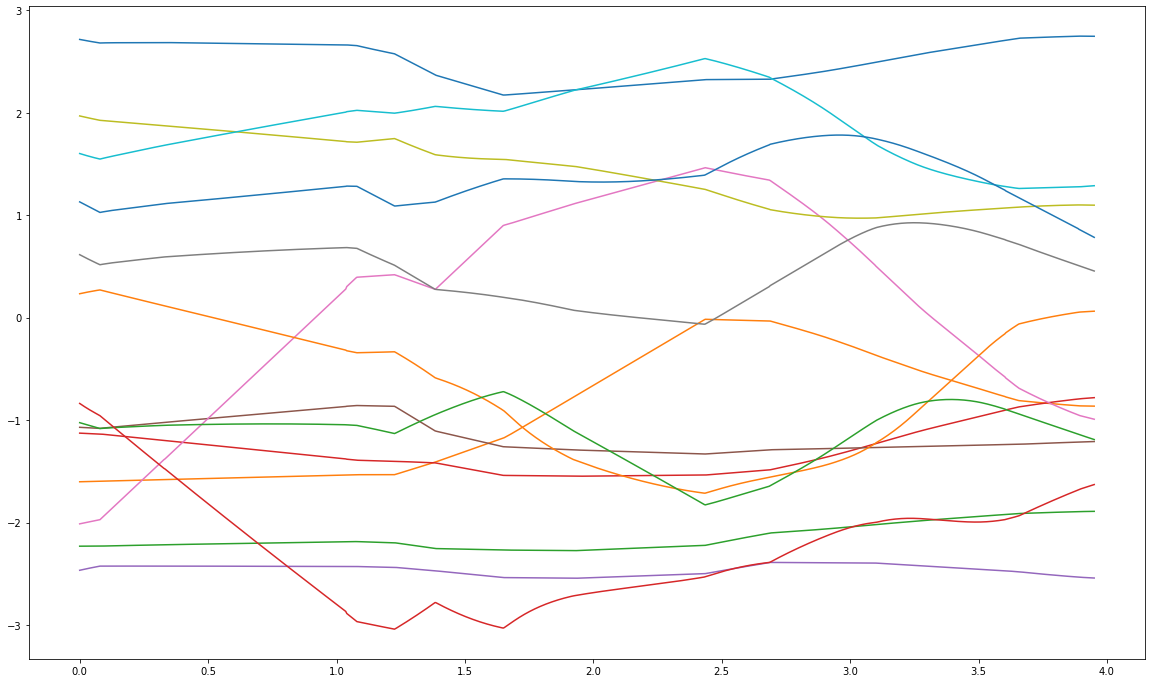

In [41]:
qs = [full_traj.value(t).flatten() for t in np.linspace(full_traj.start_time(), full_traj.end_time(), 1000)]
plt.figure(figsize=(20, 12)) # Creates a figure with 10 inches width and 6 inches height
plt.plot(np.linspace(full_traj.start_time(), full_traj.end_time(), 1000), qs)
plt.show()

In [42]:
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)

for t in np.linspace(full_traj.start_time(), full_traj.end_time(), 300):
    q = full_traj.value(t).flatten()
    plant.SetPositions(plant_context, q)
    diagram.ForcedPublish(context)
    time.sleep(0.05)